# **Development Of  Deep Learning Algorithms To Predict Particulate Matter Concentration over India.**




In [ ]:
# Import the required libraries for making dataframe
from pandas import read_csv
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Widget to upload the dataset
from google.colab import files
uploaded = files.upload()

Saving meteorogical data (1).csv to meteorogical data (1) (1).csv


           Station  PM2.5    PM10       HPBL         RH         TMP  \
Day                                                                   
2020-01-28   AJMER  35.73   72.18  34.162487  77.599998  290.179810   
2020-01-29   AJMER  35.54   58.70  22.494396  51.100002  288.200043   
2020-01-30   AJMER  35.88   74.42  24.726742  39.700001  287.451202   
2020-01-31   AJMER  39.23   90.46  22.418436  40.000000  288.109833   
2020-02-01   AJMER  47.18  117.81  22.522509  36.500000  290.215912   

            WINDIRECTION  WINDSPEED       AOD  
Day                                            
2020-01-28    290.835541   2.846474  0.818936  
2020-01-29     52.192863   3.091514  0.700829  
2020-01-30     88.736099   2.966562  1.014645  
2020-01-31    115.202057   1.244234  0.624385  
2020-02-01    108.425354   1.184651  0.695694  


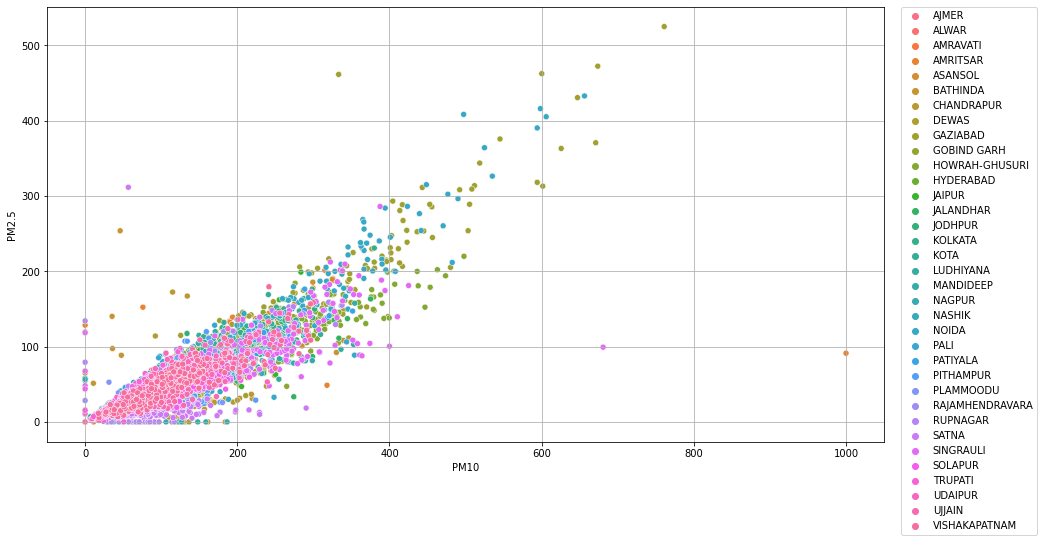

In [ ]:
# Convert csv into dataframe and parse the dates
import io
def parse(x):
  return datetime.strptime(x, '%m/%d/%y')
df = read_csv(io.BytesIO(uploaded['meteorogical data (1).csv']), parse_dates = ['Day'], index_col=0, date_parser=parse)
# df.drop('PM10', inplace=True, axis=1)
print(df.head(5))
plt.figure(figsize=(15,8))
plt.grid()
sns.scatterplot(x='PM10',y='PM2.5',data=df,hue='Station')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)


In [ ]:
# Use a dictionary of dataframes to group data of different stations
df_dict = {g: d for g, d in df.groupby('Station')}
print(df_dict.keys())
for i in df_dict.keys():
  df_dict[i].index.name = 'date'
  df_dict[i] = df_dict[i].iloc[:, 1:]
  # print(df_dict[i].head(5))
  df_dict[i].to_csv(i)

dict_keys(['AJMER', 'ALWAR', 'AMRAVATI', 'AMRITSAR', 'ASANSOL', 'BATHINDA', 'CHANDRAPUR', 'DEWAS', 'GAZIABAD', 'GOBIND GARH', 'HOWRAH-GHUSURI', 'HYDERABAD', 'JAIPUR', 'JALANDHAR', 'JODHPUR', 'KOLKATA', 'KOTA', 'LUDHIYANA', 'MANDIDEEP', 'NAGPUR', 'NASHIK', 'NOIDA', 'PALI', 'PATIYALA', 'PITHAMPUR', 'PLAMMOODU', 'RAJAMHENDRAVARA', 'RUPNAGAR', 'SATNA', 'SINGRAULI', 'SOLAPUR', 'TRUPATI', 'UDAIPUR', 'UJJAIN', 'VISHAKAPATNAM'])


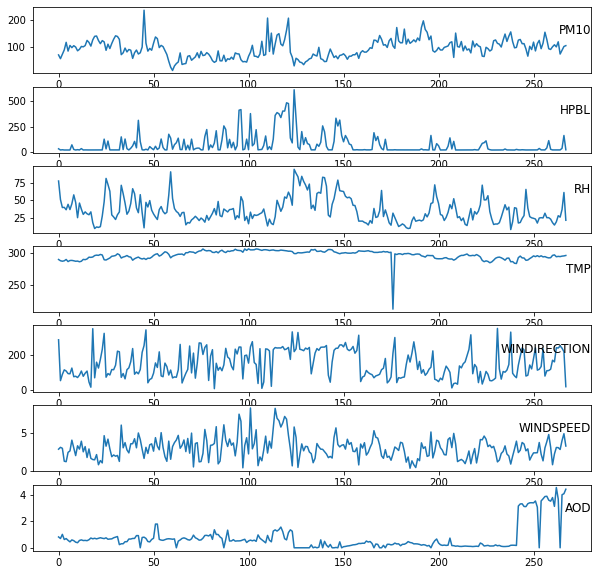

In [ ]:
# Plotting each series for AJMER station
from matplotlib import pyplot
agra = read_csv('AJMER', header=0, index_col=0)
values = agra.values
i = 1
pyplot.figure(figsize=(10,10))
# Change 7->8
for x in range(0, 7):
  pyplot.subplot(7, 1, i)
  pyplot.plot(values[:, x])
  pyplot.title(agra.columns[x], y=0.5, loc='right')
  i += 1
pyplot.show()

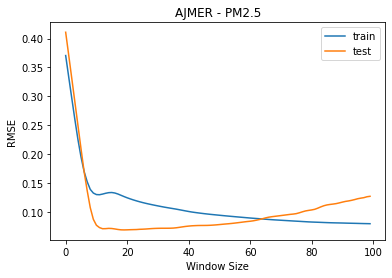

Test RMSE: 33.631


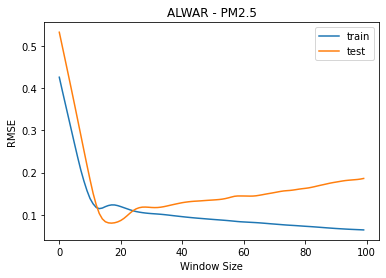

Test RMSE: 38.684


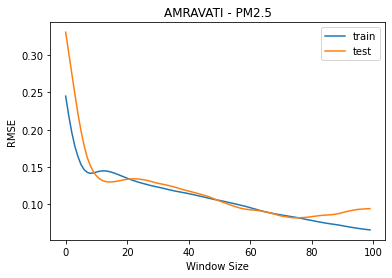

Test RMSE: 20.584


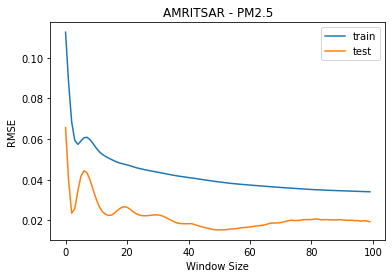

Test RMSE: 25.567


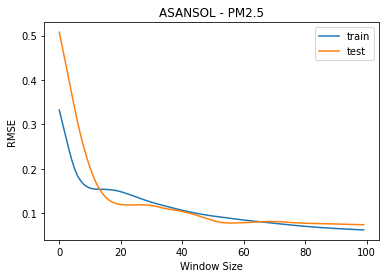

Test RMSE: 32.957


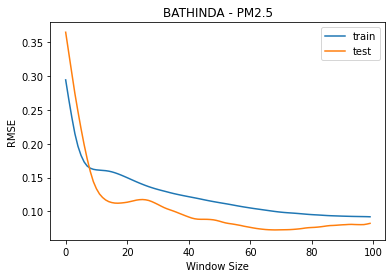

Test RMSE: 35.627


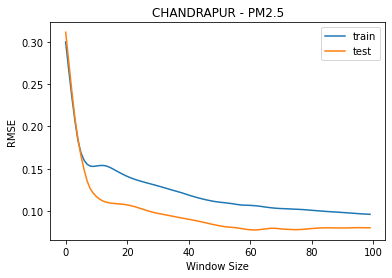

Test RMSE: 26.908


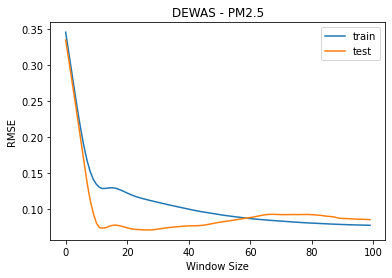

Test RMSE: 23.691


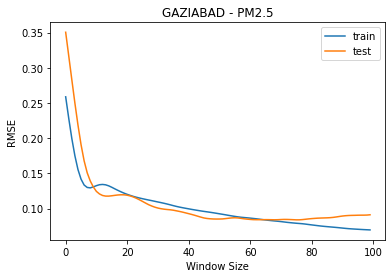

Test RMSE: 84.427


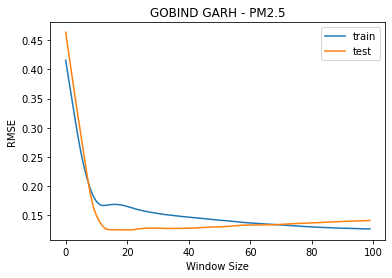

Test RMSE: 52.640


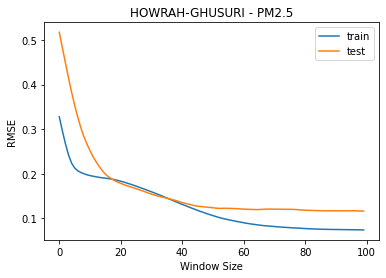

Test RMSE: 70.213


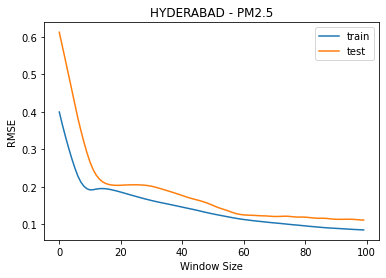

Test RMSE: 20.514


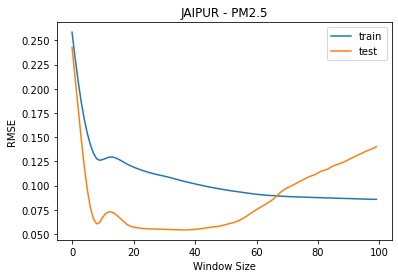

Test RMSE: 41.331


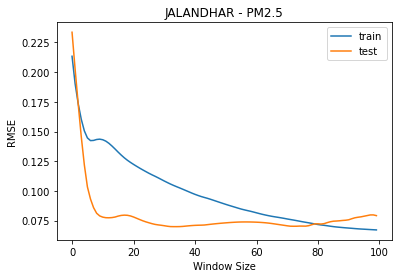

Test RMSE: 35.053


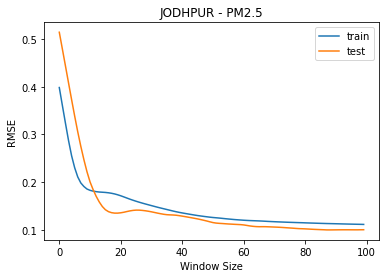

Test RMSE: 38.400


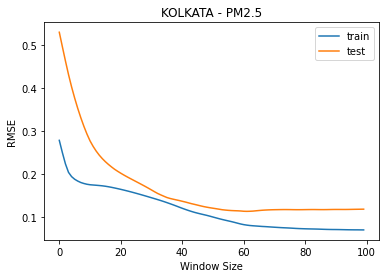

Test RMSE: 53.586


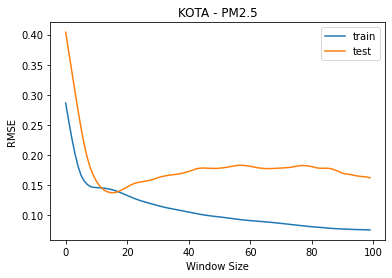

Test RMSE: 41.077


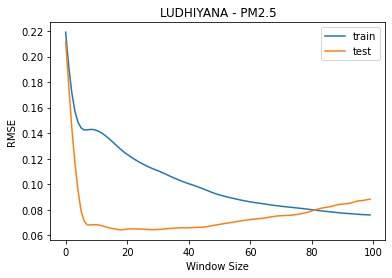

Test RMSE: 39.864


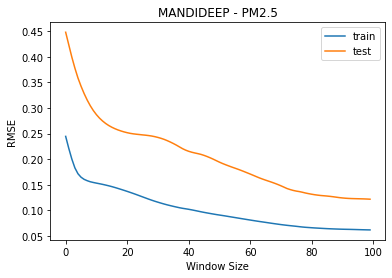

Test RMSE: 49.687


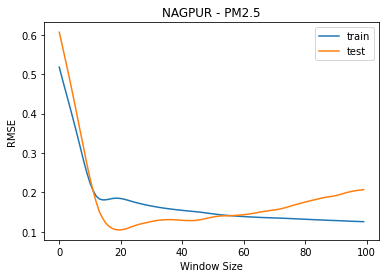

Test RMSE: 25.105


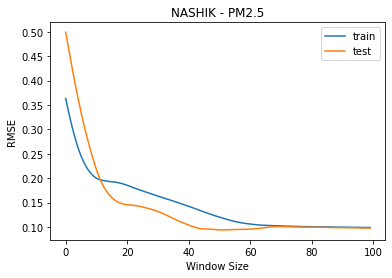

Test RMSE: 15.981


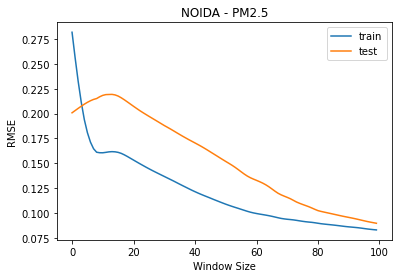

Test RMSE: 78.579


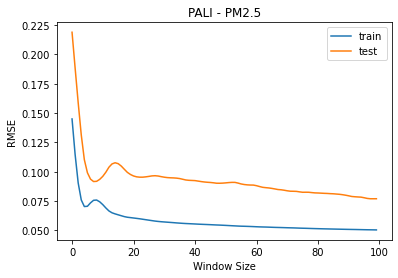

Test RMSE: 47.461


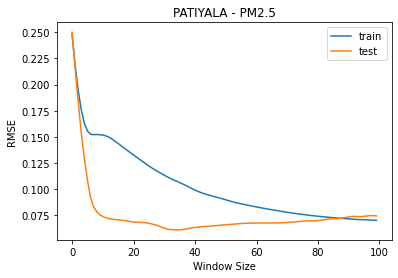

Test RMSE: 32.250


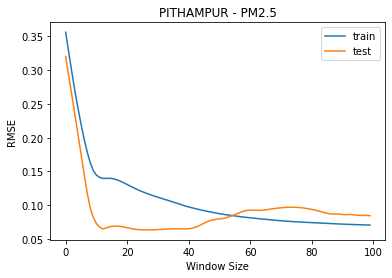

Test RMSE: 23.932


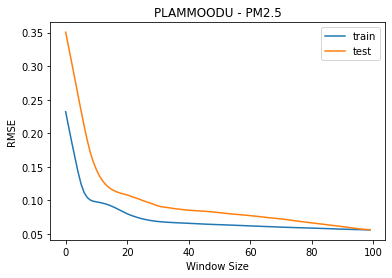

Test RMSE: 12.278


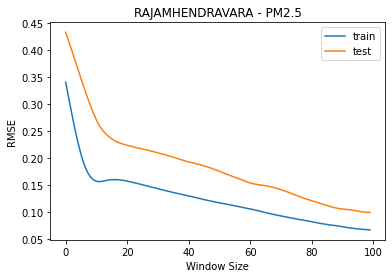

Test RMSE: 32.941


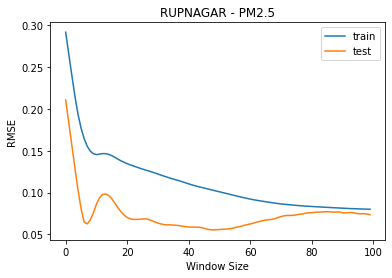

Test RMSE: 31.887


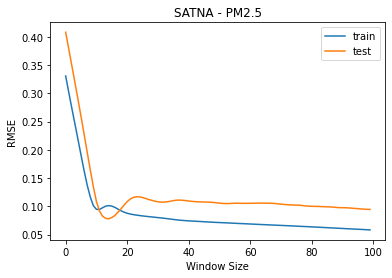

Test RMSE: 34.834


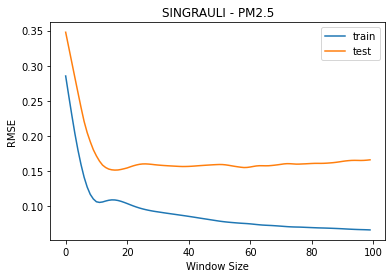

Test RMSE: 152.305


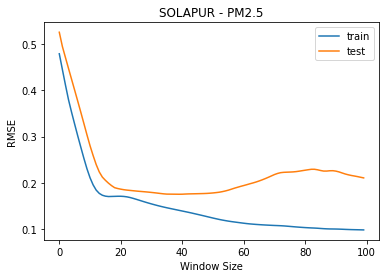

Test RMSE: 59.005


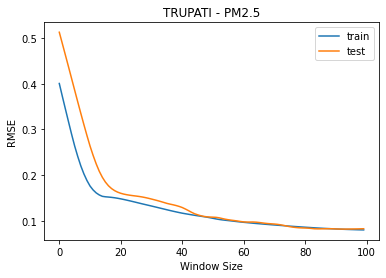

Test RMSE: 14.037


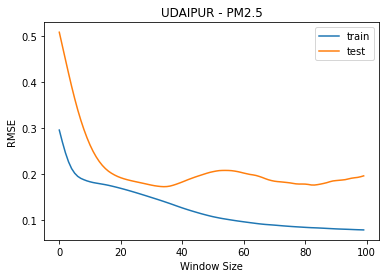

Test RMSE: 42.561


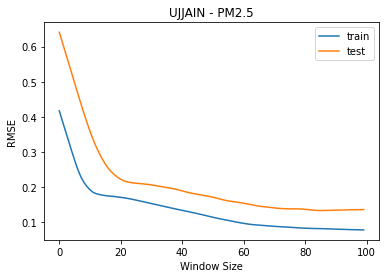

Test RMSE: 51.201


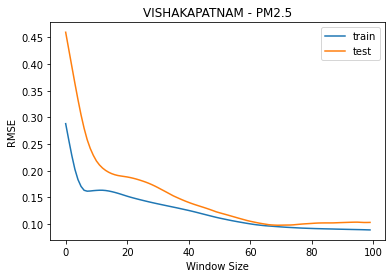

Test RMSE: 41.479


In [ ]:
# prepare data for lstm
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import matplotlib.pyplot as plt

# convert series to supervised learning
# source: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

for i in df_dict.keys():
  #load dataset
  dset = read_csv(i, header=0, index_col=0)
  values = dset.values
  # ensure all data is float
  values = values.astype('float32')
  # normalize features
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled = scaler.fit_transform(values)
  reframed = series_to_supervised(scaled, 1, 1)
	# Change to 10,...,15
  reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)

	# split into train and test sets
  values = reframed.values
  n_train_duration = 242
  train = values[:n_train_duration, :]
  test = values[n_train_duration:, :]
  # split into input and outputs
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]
  # reshape input to be 3D [samples, timesteps, features]
  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
  # print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
	# design network
  model = Sequential()
  model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
  model.add(Dense(1))
  model.compile(loss='mae', optimizer='adam')
  # fit network
  history = model.fit(train_X, train_y, epochs=100, batch_size=100, validation_data=(test_X, test_y), verbose=0, shuffle=False)
  # plot history
  pyplot.plot(history.history['loss'], label='train')
  pyplot.plot(history.history['val_loss'], label='test')
  plt.xlabel('Window Size')
  plt.ylabel('RMSE')
  # displaying the title
  plt.title(i + ' - PM2.5')
  pyplot.legend()
  pyplot.show()
	# make a prediction
  yhat = model.predict(test_X)
  test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
  # invert scaling for forecast
  inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
  inv_yhat = scaler.inverse_transform(inv_yhat)
  inv_yhat = inv_yhat[:,0]
  # invert scaling for actual
  test_y = test_y.reshape((len(test_y), 1))
  inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
  inv_y = scaler.inverse_transform(inv_y)
  inv_y = inv_y[:,0]
  # calculate RMSE
  rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
  print('Test RMSE: %.3f' % rmse)

In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc
from google.colab import drive
drive.mount('/content/drive')
!cp drive/My Drive/Colab Notebooks/LSTM.ipynb ./
!jupyter nbconvert --to PDF "Untitled.ipynb"

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
pandoc set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  javascript-common libcupsfilters1 libcupsimage2 libgs9 libgs9-common
  libijs-0.35 libjbig2dec0 libjs-jquery libkpathsea6 libpotrace0 libptexenc1
  libruby2.5 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13 lmodern
  poppler-data preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain